In [93]:
import pandas as pd

df = pd.read_excel('../../data_set/monthlyInvestigation/cleaned_monthly_investigations.xlsx')

df.sort_values(['Subject_ID', 'Month'], inplace=True)

# Create the target variable by shifting Hb column backward by 1 month for each patient
df['Next_Hb'] = df.groupby('Subject_ID')['Hb (g/dL)'].shift(-1)
df['Hb_diff'] = df['Hb (g/dL)'] - df.groupby('Subject_ID')['Hb (g/dL)'].shift(1)

df['Risk_Label'] = df['Next_Hb'].apply(lambda x: 1 if x < 10 or x > 12 else 0)


df = df.dropna(subset=['Next_Hb', 'Risk_Label', 'Hb_diff'])

feature_cols = [
    'Albumin (g/L)', 'BU - post HD', 'BU - pre HD', 'S Ca (mmol/L)',
    'SCR- post HD (µmol/L)', 'SCR- pre HD (µmol/L)',
    'Serum K Post-HD (mmol/L)', 'Serum K Pre-HD (mmol/L)',
    'Serum Na Pre-HD (mmol/L)', 'UA (mg/dL)', 'Hb (g/dL)', 'Hb_diff'
]


In [94]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df['Subject_ID']))

X_train = df.iloc[train_idx][feature_cols]
y_train = df.iloc[train_idx]['Risk_Label']

X_test = df.iloc[test_idx][feature_cols]
y_test = df.iloc[test_idx]['Risk_Label']

Classification Report (Polynomial Logistic Regression):
              precision    recall  f1-score   support

           0       0.34      0.51      0.41        45
           1       0.63      0.46      0.53        81

    accuracy                           0.48       126
   macro avg       0.49      0.48      0.47       126
weighted avg       0.53      0.48      0.49       126



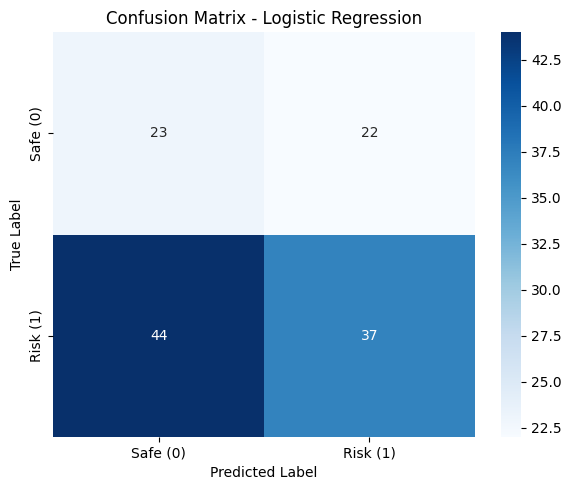

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import (
    classification_report, accuracy_score,confusion_matrix,
    roc_curve, auc, RocCurveDisplay, roc_auc_score
)
import matplotlib.pyplot as plt


# Corrected pipeline
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=1, interaction_only=False)),
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=100, random_state=42))
])

# Fit and predict
logreg_pipeline.fit(X_train, y_train)
y_pred_poly = logreg_pipeline.predict(X_test)

# Evaluate
print("Classification Report (Polynomial Logistic Regression):")
print(classification_report(y_test, y_pred_poly))

# Confusion Matrix
cm_logreg = confusion_matrix(y_test, y_pred_poly)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Safe (0)', 'Risk (1)'],
            yticklabels=['Safe (0)', 'Risk (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.show()

In [96]:
# Predictions
y_train_pred = logreg_pipeline.predict(X_train)
y_test_pred = logreg_pipeline.predict(X_test)

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")

Train Accuracy: 0.60
Test Accuracy: 0.48


AUC Score: 0.51


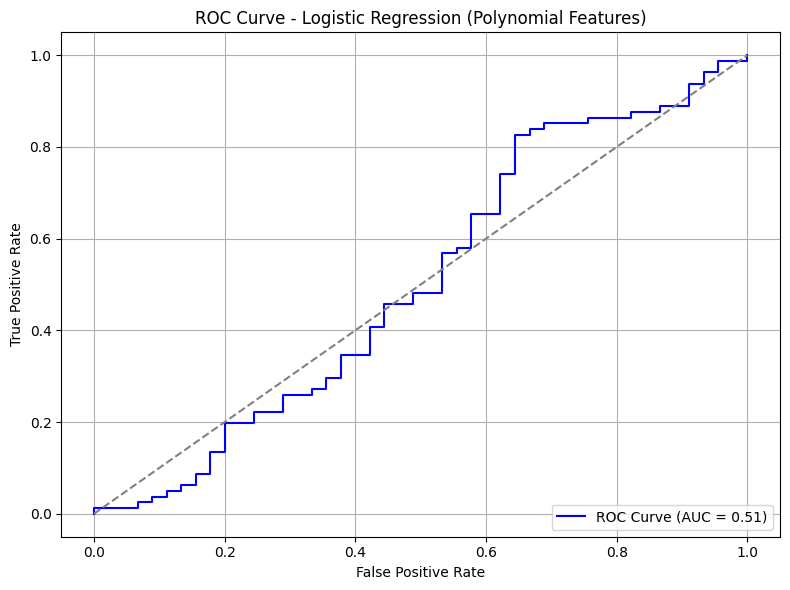

In [97]:
y_test_proba = logreg_pipeline.predict_proba(X_test)[:, 1]
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)
auc_score = roc_auc_score(y_test, y_test_proba)
print(f"AUC Score: {auc_score:.2f}")
# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (Polynomial Features)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()